# Notebook for the analysis of XPS data 

Analysis of `dati/Al_Ag_30V_3p.csv`

In [ ]:
2+2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from arpes.io import load_data
import xarray as xr


In [2]:
def load_csv_datatype(path_to_file: str, 
                      n_scans: int= 1,
                      energy_key: str = 'Energy(meas)',
                      dim_name: str = 'eV') -> xr.DataArray:
    """
    This function load a dataset in the csv format using pandas.
    the number of scans need to be manually insered. 
    If multiple scans are present the mean is considered 
    """

    df = pd.read_csv(path_to_file, skiprows=1, sep='\t')

    scan_list = [f'Scan{i}' for i in range(1,n_scans+1)]
    loaded_data = df[scan_list].mean(axis=1).to_numpy()
    
    #loaded_data = [df[key].to_numpy().T for key in scan_list]

    coords = {dim_name : df[energy_key].to_numpy()}

    return xr.DataArray(
        loaded_data,
        coords=coords,
        dims=dim_name,
        # attrs={...} <- attributes here
    )

# Load datas 
In  order to load the datas and to insert them in the `xr.DataArray` object we use a custom function. 
First we analyze the datas importing them with pandas, then we can load them using the function `load_csv_datatype`. This function allow to load datas in the correct format for the successives analysis.

In [3]:
data_path = 'dati/Al_Ag_30V_3p.csv'

df = pd.read_csv(data_path, skiprows=1, sep='\t')
df

,Energy(calc),Energy(meas),Sum,Scan1,Scan2,Scan3,Scan4,Scan5,Scan6,Scan7
0,930.0,917.73,8812,1135,1310,1192,1309,1244,1252,1370
1,929.7,917.54,8507,1066,1182,1267,1149,1327,1321,1195
2,929.4,917.19,8661,1137,1293,1264,1208,1214,1237,1308
3,929.1,916.89,8559,1062,1223,1237,1315,1241,1247,1234
4,928.8,916.53,8656,1219,1280,1243,1212,1293,1206,1203
...,...,...,...,...,...,...,...,...,...,...
196,871.2,862.85,9508,1343,1351,1383,1354,1349,1294,1434
197,870.9,862.64,9371,1356,1299,1391,1366,1294,1352,1313
198,870.6,862.29,9462,1343,1425,1390,1275,1312,1294,1423
199,870.3,861.93,9457,1289,1351,1374,1354,1341,1371,1377


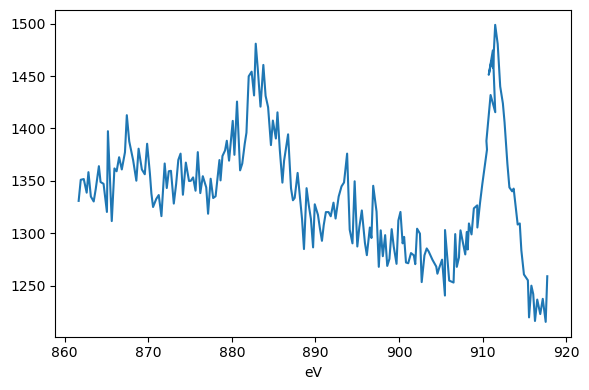

In [4]:
data = load_csv_datatype(path_to_file=data_path, n_scans=7)

# Plot datas
fig, axes = plt.subplots(1, 1, figsize=(6,4))

#data.sum("eV").S.plot(ax=axes)
data.S.plot(ax=axes)

plt.tight_layout()

# Curve fitting 

First let's try just to fit the model without subtract the background 

/var/folders/lg/r7smz1g54tj4bqh1js51y8kc0000gn/T/ipykernel_17194/2015485985.py:7: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selection = df['Energy(meas)'].between(877, 917, inclusive=False).to_numpy()


name,value,min,max,stderr,vary,expr,brute_step
a_amplitude,3160.835,0.000,inf,308.317,True,,
a_center,884.518,880.000,885.000,1.245,True,,
a_fwhm,27.790,-inf,inf,2.994,False,2.3548200*a_sigma,
a_height,106.852,-inf,inf,4.722,False,"0.3989423*a_amplitude/max(1e-15, a_sigma)",
a_sigma,11.801,0.000,inf,1.271,True,,
b_amplitude,1073.338,0.000,inf,57.421,True,,
b_center,911.986,907.000,915.000,0.102,True,,
b_fwhm,4.510,-inf,inf,0.252,False,2.3548200*b_sigma,
b_height,223.595,-inf,inf,9.665,False,"0.3989423*b_amplitude/max(1e-15, b_sigma)",
b_sigma,1.915,0.000,inf,0.107,True,,


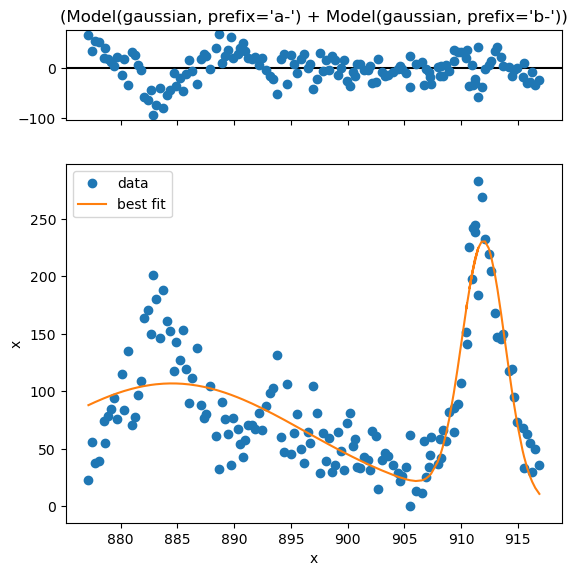

In [5]:
from arpes.fits.fit_models import GaussianModel, AffineBackgroundModel, LorentzianModel, VoigtModel
from arpes.analysis.shirley import remove_shirley_background, calculate_shirley_background_full_range
from arpes.fits.utilities import result_to_hints
#test_curve = data.spectrum.where(ws2_mask & ~wide_peak_mask).mean(["x", "y"]).sel(eV=slice(-36, -31))

# Selection
selection = df['Energy(meas)'].between(877, 917, inclusive=False).to_numpy()

test_curve = data.sel(eV=selection)
test_curve = test_curve - calculate_shirley_background_full_range(test_curve, max_iters=100)

test_model =  GaussianModel(prefix="a_") + GaussianModel(prefix="b_")

result = test_model.guess_fit(
    test_curve - test_curve.min(),
    params={
        "a_center": {"value": 883, "max":885, "min":880 },
        "a_amplitude": {"min": 0},
        "b_center": {"value": 910, "max":915, "min":907},
        "b_amplitude": {"min": 0},
    }
)
result.plot()
result

/var/folders/lg/r7smz1g54tj4bqh1js51y8kc0000gn/T/ipykernel_17194/3107024541.py:4: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  selection = df['Energy(meas)'].between(877, 917, inclusive=False).to_numpy()


name,value,min,max,stderr,vary,expr,brute_step
a_amplitude,860.849,0.000,inf,184.598,True,,
a_center,883.166,880.000,885.000,0.167,True,,
a_fwhm,5.887,-inf,inf,1.035,False,2.3548200*a_sigma,
a_height,137.372,-inf,inf,12.029,False,"0.3989423*a_amplitude/max(1e-15, a_sigma)",
a_sigma,2.500,1.400,2.500,0.439,True,,
b_amplitude,994.618,0.000,inf,69.330,True,,
b_center,912.016,907.000,915.000,0.076,True,,
b_fwhm,4.252,-inf,inf,0.235,False,2.3548200*b_sigma,
b_height,219.754,-inf,inf,9.031,False,"0.3989423*b_amplitude/max(1e-15, b_sigma)",
b_sigma,1.806,0.000,inf,0.100,True,,


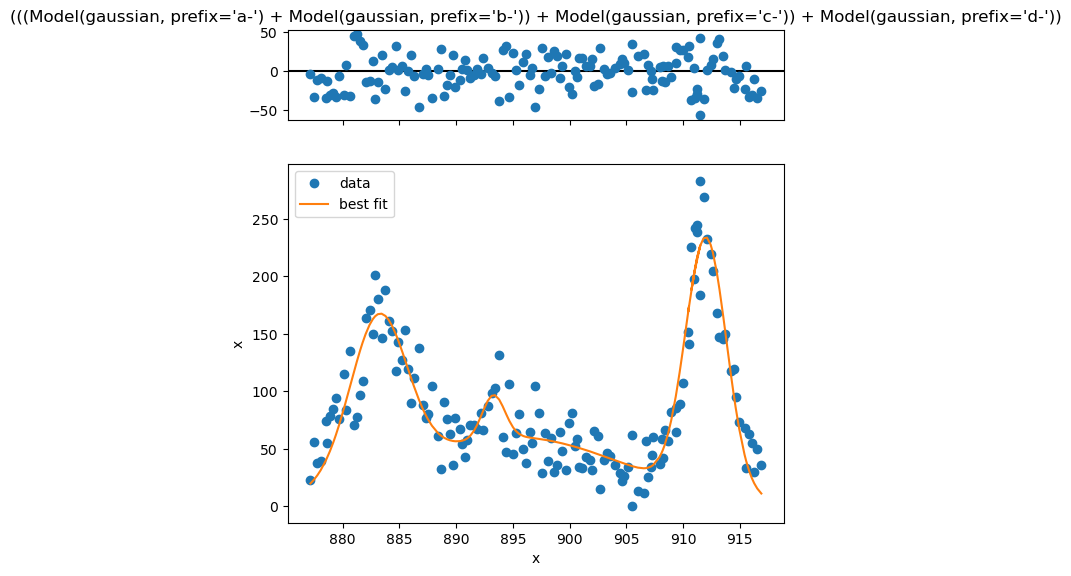

In [6]:
# test_curve = xps.spectrum.where(mask).mean(["x", "y"]).sel(eV=slice(-36, -31))
# test_curve = remove_shirley_background(test_curve)

selection = df['Energy(meas)'].between(877, 917, inclusive=False).to_numpy()
test_curve = data.sel(eV=selection)
#test_curve = remove_shirley_background(test_curve)

test_curve = test_curve - calculate_shirley_background_full_range(test_curve, max_iters=100)

test_model = GaussianModel(prefix="a_") + GaussianModel(prefix="b_") + GaussianModel(prefix="c_") + GaussianModel(prefix="d_")

result = test_model.guess_fit(
    test_curve-test_curve.min(),
    params={
        "a_center": {"value": 883, "max":885, "min":880 },
        "a_sigma": {"value": 1.5, "max": 2.5, "min": 1.4},
        "a_amplitude": {"min": 0},
        "b_center": {"value": 910, "max":915, "min":907},
        "b_amplitude": {"min": 0},
        "c_center": {"value": 894, "max": 895, "min":890},
        "c_amplitude": {"min": 0.3},
        "c_sigma":{"max": 3, "min": 1},
        "d_center": {"value": 900, "max": 905, "min":895},
        "d_amplitude": {"min": 0},
        "d_sigma":{"max": 10, "min": 1},
    }

)
result.plot()
result

In [7]:
print(result.fit_report())

[[Model]]
    (((Model(gaussian, prefix='a_') + Model(gaussian, prefix='b_')) + Model(gaussian, prefix='c_')) + Model(gaussian, prefix='d_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1011
    # data points      = 146
    # variables        = 12
    chi-square         = 69781.3663
    reduced chi-square = 520.756465
    Akaike info crit   = 924.749288
    Bayesian info crit = 960.552568
    R-squared          = 0.85792551
[[Variables]]
    a_amplitude:  860.848700 +/- 184.598308 (21.44%) (init = 0)
    a_center:     883.165627 +/- 0.16691346 (0.02%) (init = 883)
    a_sigma:      2.50000000 +/- 0.43949565 (17.58%) (init = 1.5)
    b_amplitude:  994.617972 +/- 69.3297882 (6.97%) (init = 0)
    b_center:     912.015586 +/- 0.07638966 (0.01%) (init = 910)
    b_sigma:      1.80563057 +/- 0.09984036 (5.53%) (init = 15.845)
    c_amplitude:  93.8134631 +/- 44.9986675 (47.97%) (init = 0.3)
    c_center:     893.292885 +/- 0.37197860 (0.04%) (init = 894)
   

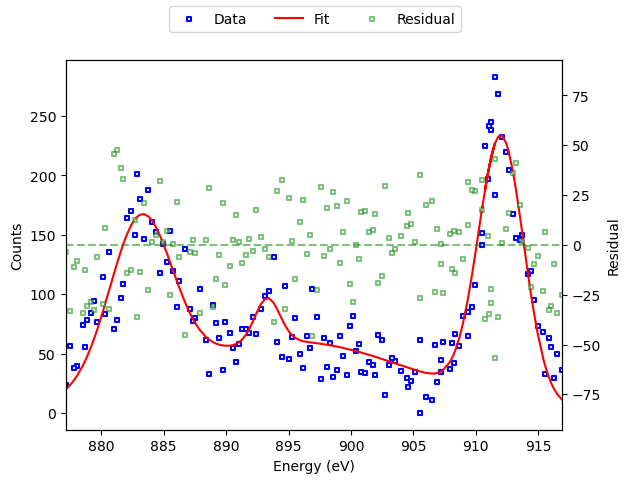

In [8]:
def plot_fit(model_result, ax=None):
    """Performs a straightforward plot of the data, residual, and fit to an axis."""
    if ax is None:
        fig, ax = plt.subplots()

    x = model_result.userkws[model_result.model.independent_vars[0]]
    ax2 = ax.twinx()
    ax2.grid(False)
    ax2.axhline(0, color="green", linestyle="--", alpha=0.5)

    ax.scatter(x, model_result.data, s=10, edgecolors="blue", marker="s", c="white", linewidth=1.5, label='Data')
    ax.plot(x, model_result.best_fit, color="red", linewidth=1.5, label='Fit')

    ax2.scatter(
        x,
        model_result.residual,
        edgecolors="green",
        alpha=0.5,
        s=12,
        marker="s",
        c="white",
        linewidth=1.5,
        label='Residual'
    )
    ylim = np.max(np.abs(np.asarray(ax2.get_ylim()))) * 1.5
    ax2.set_ylim([-ylim, ylim])
    ax.set_xlim([np.min(x), np.max(x)])
    ax2.set_ylabel('Residual')
    ax.set_ylabel('Counts')
    ax.set_xlabel('Energy (eV)')
    




fig, ax = plt.subplots(1,1)
plot_fit(result, ax=ax)

fig.legend(loc='upper center', ncol=3)